#ResNet 신경망 구조

Residual 모듈, Skip Connect 활용해 은닉층에 강한 배치 정규화

=>파라미터 층이 512개나 되는 신경망의 복잡도를 훨씬 층수가 좋은 vgg19보다 낮출 수 있었다.

### 구글 드라이브 마운트

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### CUDA 사용
런타임 유형 변경에서 선택 가능

In [17]:
import torch
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


### minssion 1-1.데이터 로더

In [18]:
import os
import zipfile
from torchvision import transforms, datasets

파일을 압축 해제하고 그 결과를 디렉토리에 저장합니다.

In [19]:
#!sudo rm -r '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab'

In [20]:
#!mkdir -p /content/drive/MyDrive/dataset/content/drive/MyDrive/Colab

In [21]:
#!unzip '/content/drive/MyDrive/dataset/kfood_train.zip' -d '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab'

In [22]:
#!unzip '/content/drive/MyDrive/dataset/kfood_val.zip' -d '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab'

In [23]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 경로 설정
train_data_dir = '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab/train'
val_data_dir = '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab/val'

In [24]:
# 데이터 전처리 설정(이미지 크기를 224x224로 조정, PyTorch Tensor로 변환)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [25]:
# 데이터셋 불러오기
data_dir = '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab/train'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 클래스 이름 얻기
class_names = dataset.classes

# 훈련 데이터셋을 훈련 및 테스트 (검증) 데이터셋으로 분할합니다.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 데이터셋을 생성합니다.
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=transform)

In [26]:
# 데이터를 훈련 세트와 테스트 세트로 나눕니다. 여기서 test_size는 테스트 세트의 비율을 나타냅니다.
train_images, test_images, train_labels, test_labels = train_test_split(
    dataset.imgs,
    [cls for _, cls in dataset.samples],
    test_size=0.2,
    random_state=42
)

In [27]:
# 데이터로더 설정
batch_size = 32 # 배치 크기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 데이터셋으로부터 클래스 이름을 얻습니다.
class_names = train_dataset.dataset.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
# 데이터로더 및 클래스 이름 출력
print(f"훈련 데이터셋 크기: {len(train_loader.dataset)}")
print(f"테스트 데이터셋 크기: {len(test_loader.dataset)}")
print(f"검증 데이터셋 크기: {len(val_loader.dataset)}")
print(f"클래스 개수: {len(class_names)}")

훈련 데이터셋 크기: 26874
테스트 데이터셋 크기: 6719
검증 데이터셋 크기: 4198
클래스 개수: 42


In [29]:
print(class_names)

['갈비구이', '갈치구이', '감자전', '경단', '계란국', '계란말이', '계란후라이', '고등어구이', '곱창구이', '김밥', '김치볶음밥', '김치전', '꿀떡', '누룽지', '닭갈비', '더덕구이', '동그랑땡', '떡갈비', '떡국_만두국', '무국', '미역국', '북엇국', '불고기', '비빔밥', '삼겹살', '새우볶음밥', '생선전', '송편', '시래기국', '알밥', '유부초밥', '육개장', '잡곡밥', '장어구이', '조개구이', '조기구이', '주먹밥', '콩나물국', '파전', '호박전', '황태구이', '훈제오리']


In [30]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load_one_image_per_class(data_folder):
    image_paths = []
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):  # 이미지 파일 확장자 확인
                    # image_paths.append(os.path.join(folder_path, file))
                    image_path = os.path.join(folder_path, file)
                    image = Image.open(image_path).convert('RGBA')
                    image_paths.append(image_path)
                    break  # 각 폴더에서 첫 번째 이미지만 가져옴
    images = [mpimg.imread(img_path) for img_path in image_paths]
    return images

# 데이터 폴더 경로
data_folder = '/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab/train'  # 실제 데이터 폴더 경로로 수정 필요

# 각 클래스 폴더에서 첫 번째 이미지를 불러옵니다.
images = load_one_image_per_class(data_folder)
print("이미지 갯수: {}".format(len(images)))

# 클래스별 이미지를 그리드로 표시
fig, axs = plt.subplots(7, 6, figsize=(20, 15))
axs = axs.ravel()

for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')  # 이미지 축 숨기기

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

##mission 1-2.model action

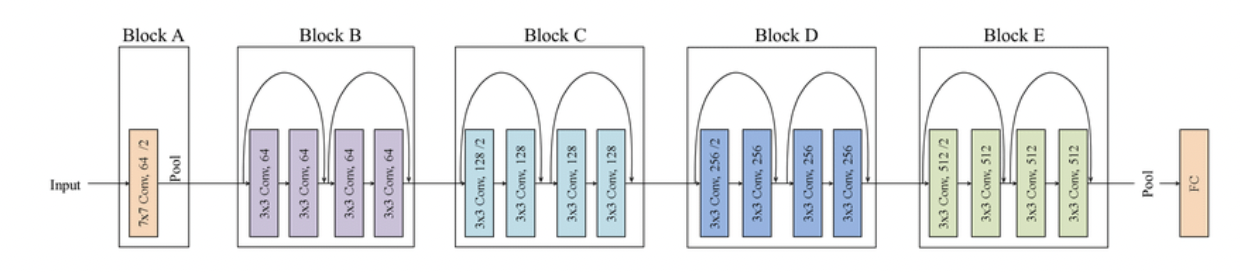

In [32]:
import torch
import torch.nn as nn

In [33]:
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [34]:
class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes*self.mul, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes*self.mul)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes*self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes*self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes*self.mul)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [35]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=42):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.mul, num_classes)

    def make_layer(self, block, out_planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

ResNet모델을 생성하고, CrossEntropy 손실 함수와 SGD 최적화 알고리즘을 사용하여 모델을 훈련합니다.

In [36]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [37]:
# 모델 인스턴스 생성
model_1 = ResNet18()

#model check

In [38]:
# 모델을 GPU로 이동 (만약 GPU를 사용할 수 있다면)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)

In [39]:
# 손실 함수 정의 (CrossEntropy를 사용합니다)
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘 정의 (SGD를 사용합니다)
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [40]:
num_epochs = 50  # 학습 epoch 수
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # gradients를 초기화합니다.
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 100 == 99:  # 매 100 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


[1,   100] loss: 3.526
[1,   200] loss: 3.177
[1,   300] loss: 3.037
[1,   400] loss: 2.889
[1,   500] loss: 2.781
[1,   600] loss: 2.700


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1,   700] loss: 2.615
[1,   800] loss: 2.589
[2,   100] loss: 2.468
[2,   200] loss: 2.416
[2,   300] loss: 2.345


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2,   400] loss: 2.332
[2,   500] loss: 2.297
[2,   600] loss: 2.285
[2,   700] loss: 2.160
[2,   800] loss: 2.213
[3,   100] loss: 2.034
[3,   200] loss: 2.015
[3,   300] loss: 2.004


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[3,   400] loss: 2.001
[3,   500] loss: 1.941
[3,   600] loss: 1.924
[3,   700] loss: 1.857
[3,   800] loss: 1.895
[4,   100] loss: 1.701
[4,   200] loss: 1.747


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4,   300] loss: 1.705
[4,   400] loss: 1.674
[4,   500] loss: 1.695
[4,   600] loss: 1.675
[4,   700] loss: 1.668
[4,   800] loss: 1.674
[5,   100] loss: 1.433
[5,   200] loss: 1.453
[5,   300] loss: 1.474


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[5,   400] loss: 1.467
[5,   500] loss: 1.479
[5,   600] loss: 1.459
[5,   700] loss: 1.429
[5,   800] loss: 1.492
[6,   100] loss: 1.292
[6,   200] loss: 1.237
[6,   300] loss: 1.263
[6,   400] loss: 1.277


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[6,   500] loss: 1.261
[6,   600] loss: 1.246
[6,   700] loss: 1.234
[6,   800] loss: 1.297
[7,   100] loss: 1.116
[7,   200] loss: 1.063


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[7,   300] loss: 1.055
[7,   400] loss: 1.074
[7,   500] loss: 1.060
[7,   600] loss: 1.061
[7,   700] loss: 1.064
[7,   800] loss: 1.114


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[8,   100] loss: 0.885
[8,   200] loss: 0.831
[8,   300] loss: 0.872
[8,   400] loss: 0.838
[8,   500] loss: 0.883
[8,   600] loss: 0.916
[8,   700] loss: 0.918
[8,   800] loss: 0.940
[9,   100] loss: 0.633
[9,   200] loss: 0.609


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[9,   300] loss: 0.688
[9,   400] loss: 0.676
[9,   500] loss: 0.746
[9,   600] loss: 0.750
[9,   700] loss: 0.759
[9,   800] loss: 0.767
[10,   100] loss: 0.461
[10,   200] loss: 0.430
[10,   300] loss: 0.437
[10,   400] loss: 0.471


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10,   500] loss: 0.496
[10,   600] loss: 0.521
[10,   700] loss: 0.577
[10,   800] loss: 0.566
[11,   100] loss: 0.331
[11,   200] loss: 0.309
[11,   300] loss: 0.316
[11,   400] loss: 0.326
[11,   500] loss: 0.326


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[11,   600] loss: 0.315
[11,   700] loss: 0.334
[11,   800] loss: 0.385
[12,   100] loss: 0.212


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[12,   200] loss: 0.178
[12,   300] loss: 0.154
[12,   400] loss: 0.175
[12,   500] loss: 0.204
[12,   600] loss: 0.199
[12,   700] loss: 0.212
[12,   800] loss: 0.216
[13,   100] loss: 0.137
[13,   200] loss: 0.090
[13,   300] loss: 0.084
[13,   400] loss: 0.098
[13,   500] loss: 0.101
[13,   600] loss: 0.112


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[13,   700] loss: 0.122
[13,   800] loss: 0.105
[14,   100] loss: 0.065
[14,   200] loss: 0.044
[14,   300] loss: 0.048


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[14,   400] loss: 0.041
[14,   500] loss: 0.048
[14,   600] loss: 0.035
[14,   700] loss: 0.052
[14,   800] loss: 0.049
[15,   100] loss: 0.025
[15,   200] loss: 0.024
[15,   300] loss: 0.035
[15,   400] loss: 0.035
[15,   500] loss: 0.036


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[15,   600] loss: 0.035
[15,   700] loss: 0.036
[15,   800] loss: 0.035
[16,   100] loss: 0.024
[16,   200] loss: 0.028


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[16,   300] loss: 0.014
[16,   400] loss: 0.015
[16,   500] loss: 0.019
[16,   600] loss: 0.018
[16,   700] loss: 0.018
[16,   800] loss: 0.025
[17,   100] loss: 0.016
[17,   200] loss: 0.009
[17,   300] loss: 0.008
[17,   400] loss: 0.010
[17,   500] loss: 0.015
[17,   600] loss: 0.016
[17,   700] loss: 0.020


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[17,   800] loss: 0.015
[18,   100] loss: 0.019
[18,   200] loss: 0.016
[18,   300] loss: 0.008


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[18,   400] loss: 0.013
[18,   500] loss: 0.011
[18,   600] loss: 0.011
[18,   700] loss: 0.008
[18,   800] loss: 0.015
[19,   100] loss: 0.012
[19,   200] loss: 0.007
[19,   300] loss: 0.006
[19,   400] loss: 0.009
[19,   500] loss: 0.008


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[19,   600] loss: 0.011
[19,   700] loss: 0.010
[19,   800] loss: 0.009
[20,   100] loss: 0.010
[20,   200] loss: 0.012
[20,   300] loss: 0.011
[20,   400] loss: 0.008
[20,   500] loss: 0.007


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[20,   600] loss: 0.007
[20,   700] loss: 0.010
[20,   800] loss: 0.009
[21,   100] loss: 0.003
[21,   200] loss: 0.006
[21,   300] loss: 0.006
[21,   400] loss: 0.007
[21,   500] loss: 0.011


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[21,   600] loss: 0.005
[21,   700] loss: 0.005
[21,   800] loss: 0.007
[22,   100] loss: 0.005


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[22,   200] loss: 0.009
[22,   300] loss: 0.009
[22,   400] loss: 0.006
[22,   500] loss: 0.007
[22,   600] loss: 0.005
[22,   700] loss: 0.006
[22,   800] loss: 0.005
[23,   100] loss: 0.005


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[23,   200] loss: 0.003
[23,   300] loss: 0.006
[23,   400] loss: 0.006
[23,   500] loss: 0.007
[23,   600] loss: 0.003
[23,   700] loss: 0.004
[23,   800] loss: 0.010
[24,   100] loss: 0.002
[24,   200] loss: 0.008
[24,   300] loss: 0.004


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24,   400] loss: 0.006
[24,   500] loss: 0.009
[24,   600] loss: 0.004
[24,   700] loss: 0.003
[24,   800] loss: 0.007
[25,   100] loss: 0.003
[25,   200] loss: 0.003


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[25,   300] loss: 0.007
[25,   400] loss: 0.006
[25,   500] loss: 0.006
[25,   600] loss: 0.003
[25,   700] loss: 0.006
[25,   800] loss: 0.008
[26,   100] loss: 0.003


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[26,   200] loss: 0.003
[26,   300] loss: 0.005
[26,   400] loss: 0.007
[26,   500] loss: 0.006
[26,   600] loss: 0.003
[26,   700] loss: 0.004
[26,   800] loss: 0.006
[27,   100] loss: 0.004
[27,   200] loss: 0.003
[27,   300] loss: 0.003


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[27,   400] loss: 0.008
[27,   500] loss: 0.006
[27,   600] loss: 0.005
[27,   700] loss: 0.003
[27,   800] loss: 0.003
[28,   100] loss: 0.004
[28,   200] loss: 0.005
[28,   300] loss: 0.003
[28,   400] loss: 0.003
[28,   500] loss: 0.004


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[28,   600] loss: 0.004
[28,   700] loss: 0.006
[28,   800] loss: 0.005
[29,   100] loss: 0.003
[29,   200] loss: 0.004
[29,   300] loss: 0.005
[29,   400] loss: 0.003
[29,   500] loss: 0.002
[29,   600] loss: 0.002


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[29,   700] loss: 0.005
[29,   800] loss: 0.005
[30,   100] loss: 0.002
[30,   200] loss: 0.002
[30,   300] loss: 0.005
[30,   400] loss: 0.005
[30,   500] loss: 0.003
[30,   600] loss: 0.004


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[30,   700] loss: 0.003
[30,   800] loss: 0.004
[31,   100] loss: 0.003
[31,   200] loss: 0.004
[31,   300] loss: 0.003
[31,   400] loss: 0.002
[31,   500] loss: 0.007
[31,   600] loss: 0.004
[31,   700] loss: 0.003


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[31,   800] loss: 0.004


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[32,   100] loss: 0.002
[32,   200] loss: 0.002
[32,   300] loss: 0.003
[32,   400] loss: 0.004
[32,   500] loss: 0.004
[32,   600] loss: 0.004
[32,   700] loss: 0.005
[32,   800] loss: 0.005
[33,   100] loss: 0.002
[33,   200] loss: 0.004
[33,   300] loss: 0.003
[33,   400] loss: 0.003
[33,   500] loss: 0.005
[33,   600] loss: 0.002
[33,   700] loss: 0.006


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[33,   800] loss: 0.003
[34,   100] loss: 0.003


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[34,   200] loss: 0.003
[34,   300] loss: 0.001
[34,   400] loss: 0.003
[34,   500] loss: 0.002
[34,   600] loss: 0.006
[34,   700] loss: 0.003
[34,   800] loss: 0.004
[35,   100] loss: 0.003
[35,   200] loss: 0.002
[35,   300] loss: 0.002


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[35,   400] loss: 0.002
[35,   500] loss: 0.004
[35,   600] loss: 0.004
[35,   700] loss: 0.005
[35,   800] loss: 0.004
[36,   100] loss: 0.002


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[36,   200] loss: 0.002
[36,   300] loss: 0.004
[36,   400] loss: 0.002
[36,   500] loss: 0.001
[36,   600] loss: 0.004
[36,   700] loss: 0.003
[36,   800] loss: 0.004
[37,   100] loss: 0.003
[37,   200] loss: 0.002
[37,   300] loss: 0.005
[37,   400] loss: 0.002


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[37,   500] loss: 0.004
[37,   600] loss: 0.004
[37,   700] loss: 0.005
[37,   800] loss: 0.004
[38,   100] loss: 0.003
[38,   200] loss: 0.002


FileNotFoundError: ignored

In [ ]:
import torch
from torchvision import models
# 모델 저장
PATH = '/content/drive/MyDrive/dataset/Resnet18_kfood.pt'
torch.save(model_1.state_dict(), PATH)

In [ ]:
from torchvision import transforms, datasets
# Validation 데이터셋 불러오기
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/content/drive/MyDrive/Colab/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

correct = 0
total = 0
# 모델을 평가 모드로 설정
model_1.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Validation 데이터에 대한 정확도: %d %%' % (100 * correct / total))